In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch as t
import transformers
import peft
from sklearn.utils import check_random_state
import json

/home/koen/.pyenv/versions/3.11.6/envs/mihracle/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


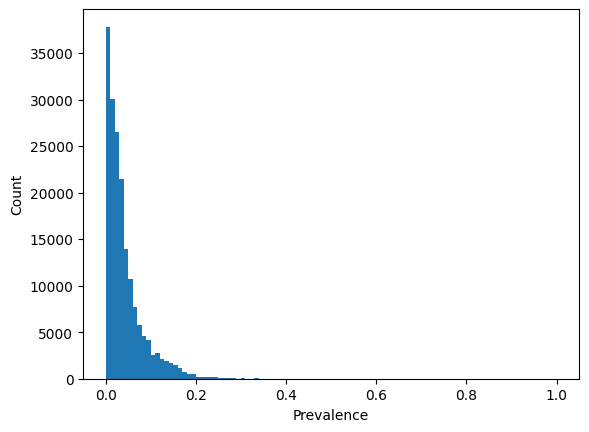

In [8]:
data_path = Path("./data/prevalence_dataset_doc_bert_nli_500K/")
global_labels = t.load(data_path / "local_prevalences_tensor.pkl")[:,2].float()

global_labels = global_labels[t.where(global_labels > 0.0)]
# global_labels = t.log(global_labels + 0.01)
global_labels = (global_labels - global_labels.min()) / (
   global_labels.max() - global_labels.min()
)
global_labels = global_labels.numpy().squeeze()

plt.hist(global_labels, bins=100)
plt.xlabel("Prevalence")
plt.ylabel("Count")
plt.show()

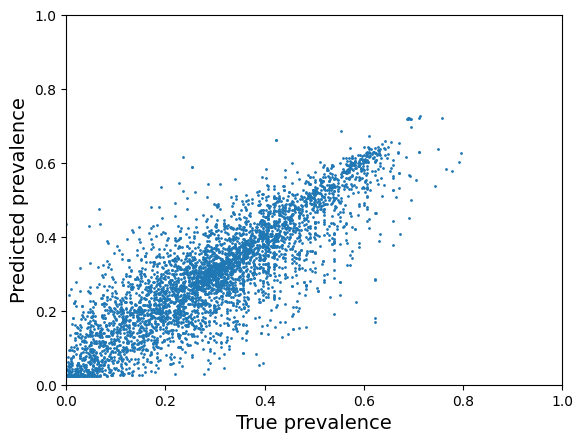

rae
0.8713271
26.62857
mae
0.062139913
0.06035736


In [24]:
directory = Path("./models/prevalence/local/bert-1024-nolora/fold_0/")
# directory = Path("/mnt/storage/datasets/mihracle/models/prevalence/xlm-roberta-global-lorano/fold_0/")
# directory = Path("/mnt/storage/datasets/mihracle/models/prevalence/xlm-roberta-global-lora8-100k-1epoch_log_test/fold_0/")
predictions = np.load(directory / "predictions.npy")
# sigmoid of predictions
labels = np.load(directory / "labels.npy")
plt.scatter(labels, predictions, s=1)
# plt.hist(labels, bins=100, alpha=0.5, density=True, stacked=True)
# plt.hist(predictions, bins=100, alpha=0.5, density=True, stacked=True)
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xlabel("True prevalence", fontsize=14)
plt.ylabel("Predicted prevalence", fontsize=14)
plt.show()

rae = np.abs(labels.squeeze() - predictions.squeeze()) / (labels.squeeze() + 1e-8)
ae = np.abs(labels.squeeze() - predictions.squeeze())
print("rae")
print(np.mean(rae))
print(np.std(rae))
print("mae")
print(np.mean(ae))
print(np.std(ae))

In [4]:
import json 
with open("/mnt/storage/datasets/mihracle/models/prevalence/local/checkpoints/xlm-roberta-longformer/checkpoint-7100/trainer_state.json") as f:
    trainer_state = json.load(f)

print(trainer_state)

loss_history = [x["loss"] for x in trainer_state["log_history"] if "loss" in x]
plt.plot(loss_history)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/storage/datasets/mihracle/models/prevalence/local/checkpoints/xlm-roberta-longformer/checkpoint-7100/trainer_state.json'

In [5]:


def read_json(path):
    with open(path) as f:
        return json.load(f)

def read_jsonl(path):
    with open(path) as f:
        return [json.loads(line) for line in f]


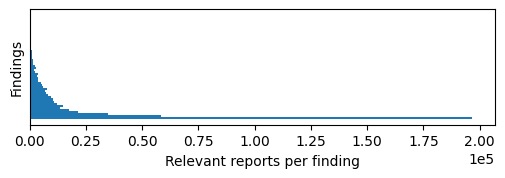

[1662  730  523  392  364  264  265  237  178  216  149  123  146  122
  108  116  109   93   75   76   82   70   62   66   58   67   48   48
   64   64   50   42   44   32   50   51   44   63   41   49   45   51
   32   61   40   33   40   41   46   38   30   38   34   30   29   20
   33   46   41   35   30   33   40   24   26   34   32   34   25   28
   26   21   19   27   28   25   25   26   25   21   19   21   26   21
   23   25   23   26   31   24   23   21   17   17   22   18   21   20
   15   23   16   20   14   30   15   12   20   15    8   12   14   11
   14   13   12   13   16   11    9   12   14   10    4   14   16    8
   10    9   16    9   10   17    6   17    8    6    6    9    7    9
    8    4    5    7    6   14    8    6   11    8    4    7   10    9
    8    9    5    5    7    5    4    7    9    3    5    6    6    4
    4    3    6    7    3    5    5    2    5    4    2    6    3    7
    1    6    6    1    1    7    3    2    3    3    4    1    8    9
    2 

In [53]:
data = read_json("data/prevalence_dataset_doc_bert_nli_cache_sample/comparison_cache.json")

plt.figure(figsize=(6, 1.5))
plt.hist([len(x) for x in list(data.values())*50], orientation="horizontal", bins=50)
plt.ylabel("Findings")
plt.xlabel("Relevant reports per finding")
plt.yticks([] ,[])
plt.gca().ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.show()

c, b = np.histogram([len(x) for x in list(data.values())], bins=300)
print(c, b)
print(np.sum(c[:1]) / np.sum(c))
print(np.sum(c[1:4]) / np.sum(c))
print(np.sum(c[4:10]) / np.sum(c))
print(np.sum(c[10:50]) / np.sum(c))
print(np.sum(c[50:150]) / np.sum(c))
print(np.sum(c[150:]) / np.sum(c))

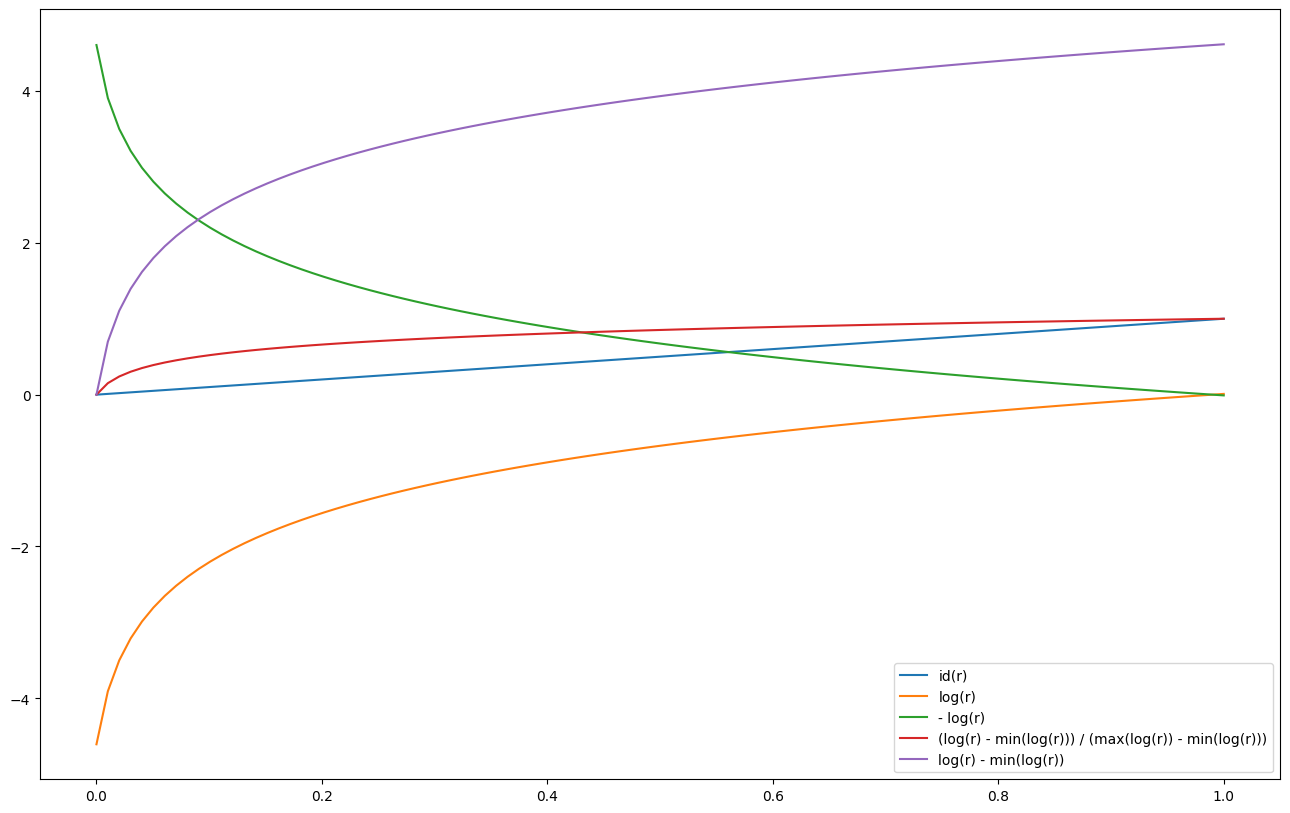

In [7]:
r = t.linspace(0, 1, 100)
log_r = t.log(r + 0.01)
plt.figure(figsize=(16, 10))
plt.plot(r, r, label="id(r)")
plt.plot(r, log_r, label="log(r)")
plt.plot(r, -log_r, label="- log(r)")
plt.plot(r, (log_r - log_r.min()) / (log_r.max() - log_r.min()), label="(log(r) - min(log(r))) / (max(log(r)) - min(log(r)))")
plt.plot(r, log_r - log_r.min(), label="log(r) - min(log(r))")
plt.legend()
plt.show()

In [41]:
# Get the scores for the prevalence table (how the hell did I make these for the paper???)
from sklearn.metrics import r2_score

directory = "models/prevalence/local/bert-1024-nolora/fold_2/"
labels = np.load(directory + "labels.npy")
predictions = np.load(directory + "predictions.npy")

mae = np.mean(np.abs(labels.squeeze() - predictions.squeeze()))
mae_std = np.std(np.abs(labels.squeeze() - predictions.squeeze()))
mrae = np.mean(np.abs(labels.squeeze() - predictions.squeeze()) / (labels.squeeze() + 1e-8))
mrae_std = np.std(np.abs(labels.squeeze() - predictions.squeeze()) / (labels.squeeze() + 1e-8))
r2 = r2_score(labels.squeeze(), predictions.squeeze(), multioutput="variance_weighted")

print(f"MAE: {mae:.3f} ± {mae_std:.3f}")
print(f"MRAE: {mrae:.3f} ± {mrae_std:.3f}")
print(f"R2: {r2:.3f}")

MAE: 0.063 ± 0.061
MRAE: 0.511 ± 2.256
R2: 0.694


In [48]:
# compare significance
model_a = "models/prevalence/global/sent_sim_bert_lora2_500K/"
model_b = "models/prevalence/global/sent_sim_bert_nolora_500K/"

from scipy.stats import ttest_ind

mae_a = [read_json(model_a + f"fold_{i}/metrics.json")["test_mae"] for i in range(3)]
mae_b = [read_json(model_b + f"fold_{i}/metrics.json")["test_mae"] for i in range(3)]

ttest_ind(mae_a, mae_b, alternative="greater")

TtestResult(statistic=5.737093417323622, pvalue=0.0022863220196547842, df=4.0)